#  MODIS Water Cluster Training

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

In [ ]:
import csv
import datetime
import glob
import joblib
import pickle
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

plt.rcParams['figure.facecolor'] = 'white'
# plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline


import optuna
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
#from sklearn.inspection import permutation_importance


# #GDAL Stuff
# from osgeo import gdalconst
# from osgeo import gdal
# from pprint import pprint

# GPU-based frameworks

# import cudf
# import cupy as cp
# from cuml.ensemble import RandomForestClassifier as cuRFC

## Parameters and Functions

In [2]:
GPU = False
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5
num_datapoints = 100000000

In [3]:
outlier_threshold = None 
# outlier_threshold = 10000

"Unhighlight" different versions for input

In [4]:
# #############################
# # VERSION 4.2.1 (targeted 500k points)
# TILE_IN = 'Golden'#v4.2.1
# DATA_VERSION='v4.2.1'
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
# #############################

##############################
#VERSION 2.0.1 (5 million points)
TILE_IN = 'GLOBAL'#v2.0.1
DATA_VERSION='v2.0.1'
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
##############################

# #############################
# #VERSION 0.0.0 (2billion data points)
# TILE_IN = 'cleaned'#v2.0.1
# DATA_VERSION='AGU'
# offsets_indexes = []#'x_offset', 'y_offset', 'year', 'julian_day']
# ##############################

training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

print(data_paths)
data_path = data_paths[0]
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip


In [5]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
            dataType=np.int16, cpu=True, splitXY=False, trainTestSplit=False,
            applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
            multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]

    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

Change the input features below

In [6]:
colsToDrop = [
            # 'sur_refl_b01_1','sur_refl_b02_1',
            'sur_refl_b03_1','sur_refl_b04_1',
            'sur_refl_b05_1','sur_refl_b06_1',
            # 'sur_refl_b07_1', 'ndvi',
            'ndwi1','ndwi2'
            ]

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1',
           'sur_refl_b03_1','sur_refl_b04_1',
           'sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi',
           'ndwi1','ndwi2']

In [7]:
colsToDrop

['sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'sur_refl_b06_1',
 'ndwi1',
 'ndwi2']

## Input data

In [8]:
%%time
X, X_test, y, y_test = load_data(fpath=data_path,
             colsToDrop=colsToDropTraining,
             dataType=DATA_TYPE,
             splitXY=True,
             imbalance=False,
             trainTestSplit=True)

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'data shape: {X.shape}, {y.shape}')

data shape: (4375821, 4), (4375821,)
CPU times: user 3.36 s, sys: 1.02 s, total: 4.38 s
Wall time: 3.91 s


Thresholding out outliers

In [9]:
if outlier_threshold is not None:
    #keep the values below the outlier threshold
    X_no_outlier = X[X['sur_refl_b01_1'] < outlier_threshold]
    y_no_outlier = y.loc[X_no_outlier.index]

    print(f'Removing {len(X) - len(X_no_outlier)} outliers')

Separating land and water datapoints

In [10]:
if outlier_threshold is None:
    features = X
    label = y
else: 
    print(f'Dataset with no outliers greater than {outlier_threshold}')
    features = X_no_outlier
    label = y_no_outlier
    
#Getting the indices that are associated with land (0) and water (1)
water_ind = np.where(label>0.5)[0]
land_ind = np.where(label<0.5)[0]

#Subset the X AND y data to later/ subset with the clusters and then combine for RFA
X_water = features.iloc[water_ind,:]
y_water = label.iloc[water_ind]

X_land = features.iloc[land_ind,:]
y_land = label.iloc[land_ind]

print(f'Water datapoints: {len(X_water)}, Land datapoints: {len(X_land)}')

Water datapoints: 1976934, Land datapoints: 2398887


In [11]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b07_1
ndvi


## Clustering

Based on the cluster analysis above on 5.03.23, 15 clusters appears to have the most data and exclude outliers so will use that number for selection 

In [75]:
kmean_land_fit_file = 'kmeans_land_fit.pkl'
kmean_water_fit_file = 'kmeans_water_fit.pkl'
# if len(glob.glob(kmean_land_fit_file)) == 1:
#     print(f"Opening {kmean_land_fit_file}")
#     kme_land_random = pickle.load(open(kmean_land_fit_file, 'rb'))
# if len(glob.glob(kmean_water_fit_file)) == 1:
#     print(f"Opening {kmean_water_fit_file}")
#     kme_water_random = pickle.load(open(kmean_water_fit_file, 'rb'))

In [83]:
kme_land_random = pickle.load(open(kmean_land_fit_file, 'rb'))
kmeans_output_land_random = kme_land_random.predict(X_land)

In [82]:
kme_water_random = pickle.load(open(kmean_water_fit_file, 'rb'))
kmeans_output_water_random = kme_water_random.predict(X_water)

In [30]:
# CLUSTER_NUM=15

# common_params = {
#     # "n_init": "auto",
#     "random_state": 42,
#     "init":"random"
# }

In [31]:
# %%time
# kme_water_random = KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
# kmeans_output_water_random = kme_water_random.predict(X_water)

CPU times: user 1min 4s, sys: 1.27 s, total: 1min 6s
Wall time: 16.8 s


In [32]:
# %%time
# kme_land_random = KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
# kmeans_output_land_random = kme_land_random.predict(X_land)

CPU times: user 1min 57s, sys: 2.18 s, total: 1min 59s
Wall time: 30.3 s


In [73]:
# pickle.dump(kme_land_random, open("kmeans_land_fit.pkl", "wb"))
# pickle.dump(kme_water_random, open("kmeans_water_fit.pkl", "wb"))

### Evenly balanced cluster data

In [84]:
COUNT_EVEN_BALANCE_LAND = np.inf
COUNT_EVEN_BALANCE_WATER = np.inf
for cluster in np.unique(kmeans_output_water_random):
    land_num = len(np.where(kmeans_output_land_random == cluster)[0])
    water_num = len(np.where(kmeans_output_water_random == cluster)[0])
    if land_num < COUNT_EVEN_BALANCE_LAND: COUNT_EVEN_BALANCE_LAND = land_num
    if water_num < COUNT_EVEN_BALANCE_WATER: COUNT_EVEN_BALANCE_WATER = water_num
    
print(COUNT_EVEN_BALANCE_LAND, COUNT_EVEN_BALANCE_WATER)
if COUNT_EVEN_BALANCE_LAND < COUNT_EVEN_BALANCE_WATER:
    COUNT = COUNT_EVEN_BALANCE_LAND
else: 
    COUNT = COUNT_EVEN_BALANCE_WATER
print(COUNT,COUNT_EVEN_BALANCE_LAND,COUNT_EVEN_BALANCE_WATER)

893 8685
893 893 8685


In [85]:
np.random.seed(42)
cluster_sample_land = np.array([])
cluster_sample_water = np.array([])

for cluster in np.unique(kmeans_output_water_random):
    
    cluster_water = np.where(kmeans_output_water_random == cluster)[0]
    sample_water = np.random.choice(cluster_water,COUNT,replace=False)
    if outlier_threshold is None: 
        max_X_random_water = np.nanmax(X_water['sur_refl_b01_1'].iloc[sample_water])
        #remove the entire cluster with outlier not just single datapoints
        if max_X_random_water > 10000:
            outlier_cluster=cluster
            print(f'cluster {cluster} contains outliers')
            continue
        else: cluster_sample_water = np.append(cluster_sample_water, sample_water)
    else: cluster_sample_water = np.append(cluster_sample_water, sample_water)
    print(f'cluster {cluster}')  
    cluster_land= np.where(kmeans_output_land_random == cluster)[0]
    sample_land = np.random.choice(cluster_land,COUNT,replace=False)
    cluster_sample_land = np.append(cluster_sample_land, sample_land)
    
cluster_sample_water = cluster_sample_water.astype('int')
cluster_sample_land = cluster_sample_land.astype('int')

print(len(cluster_sample_water),len(cluster_sample_land))

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5
cluster 6
cluster 7
cluster 8
cluster 9
cluster 10
cluster 11
cluster 12
cluster 13
cluster 14 contains outliers
12502 12502


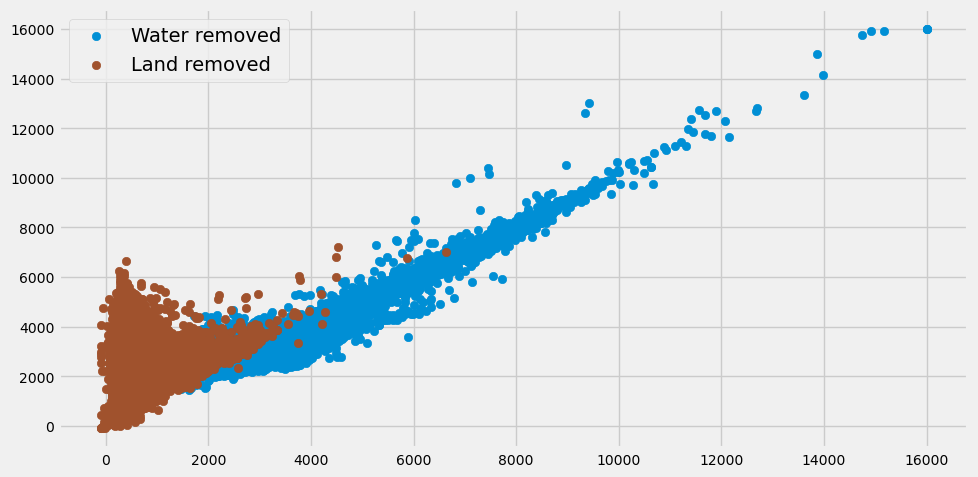

In [45]:
outlier_clus = np.where(kmeans_output_water_random == outlier_cluster)[0]

plt.figure(figsize=(10, 5))
plt.tick_params(axis='both', which='major', labelsize=10)
plt.scatter(X_water['sur_refl_b01_1'].iloc[outlier_clus].values, 
            X_water['sur_refl_b02_1'].iloc[outlier_clus].values, label='Water removed')
plt.scatter(X_land['sur_refl_b01_1'].iloc[outlier_clus].values, 
            X_land['sur_refl_b02_1'].iloc[outlier_clus].values, label='Land removed',color='sienna')
plt.legend()
plt.tight_layout()
plt.savefig('land_water_removed_values.png',dpi=300)
plt.show()
plt.close()


#### Combining even balance cluster data

In [39]:
X_seperate_cluster = pd.concat([
    X_land.iloc[cluster_sample_land],X_water.iloc[cluster_sample_water]
    ])
    
y_seperate_cluster = pd.concat([
    y_land.iloc[cluster_sample_land],y_water.iloc[cluster_sample_water]
    ])

#Combine the data so that we can shuffle the indices and keep the data together that should be
all_cluster = pd.concat([X_seperate_cluster,y_seperate_cluster],axis=1).sample(frac=1)
X_cluster = all_cluster[X_seperate_cluster.columns]
y_cluster = all_cluster['water']

# print(all_cluster)
# print(X_cluster)
# print(y_cluster)


Plot with the indvidual clusters highlighted

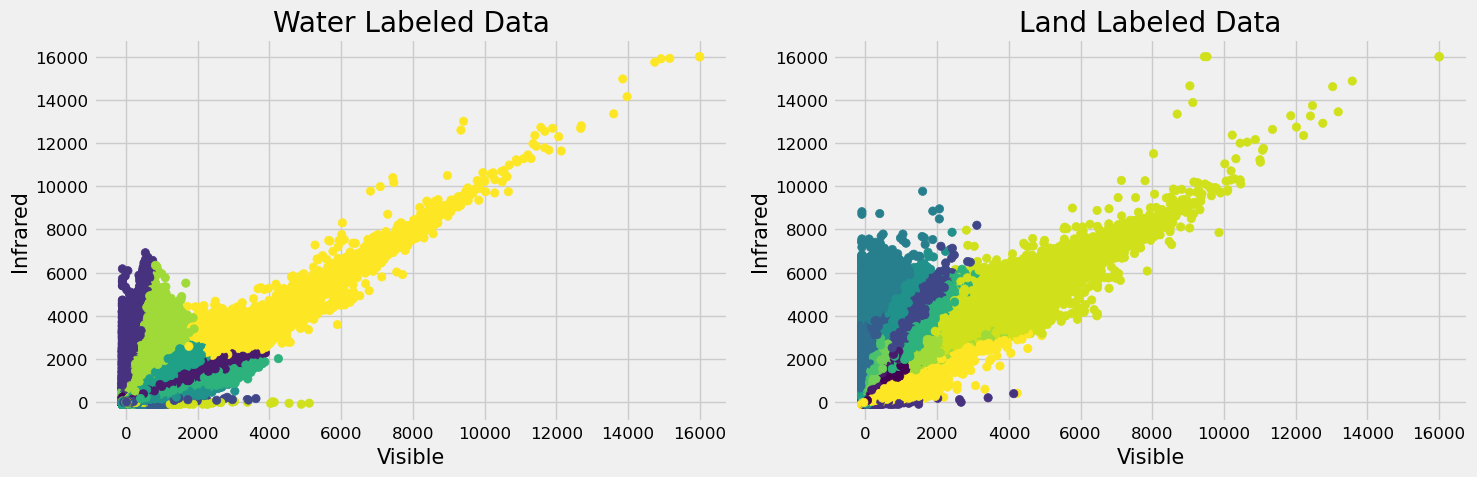

In [42]:
fig, ax =  plt.subplots(1, 2,figsize=(15, 5))

cluster_X_land = X_land.iloc[cluster_sample_land]
cluster_X_water = X_water.iloc[cluster_sample_water]

tick_size = 12
label_s = 15

ax[0].tick_params(axis='both', which='major', labelsize=tick_size)
ax[0].scatter(X_water['sur_refl_b01_1'],X_water['sur_refl_b02_1'],c=kmeans_output_water_random)
ax[0].set_title("Water Labeled Data")
ax[0].set_xlabel('Visible',size=label_s)
ax[0].set_ylabel('Infrared',size=label_s)

ax[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax[1].scatter(X_land['sur_refl_b01_1'],X_land['sur_refl_b02_1'],c=kmeans_output_land_random) #,cmap='PuRd')
ax[1].set_title("Land Labeled Data")
# ax[1].set_xlim(0,10000)
ax[1].set_xlabel('Visible',size=label_s)
ax[1].set_ylabel('Infrared',size=label_s)

plt.tight_layout()
plt.savefig('Water_land_clusters.png',dpi=300)
plt.show()

Plot with the total and cluster data seperate

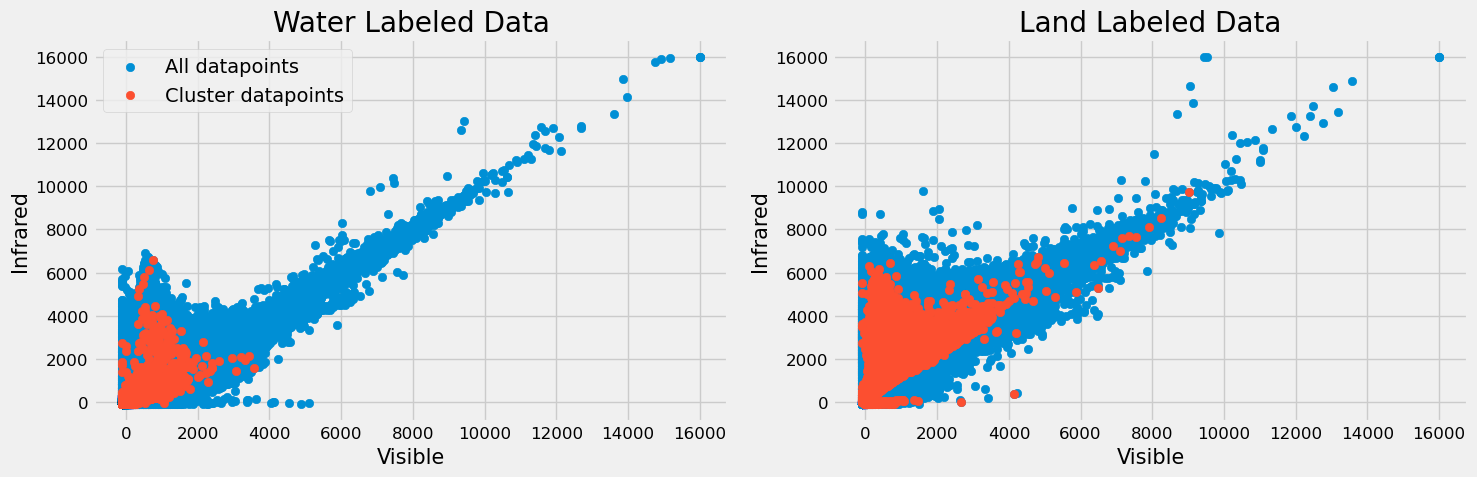

In [46]:
fig, ax =  plt.subplots(1, 2,figsize=(15, 5))

cluster_X_land = X_land.iloc[cluster_sample_land]
cluster_X_water = X_water.iloc[cluster_sample_water]

tick_size = 12
label_s = 15

ax[0].tick_params(axis='both', which='major', labelsize=tick_size)
ax[0].scatter(X_water['sur_refl_b01_1'],X_water['sur_refl_b02_1'],label='All datapoints')#,cmap='PuRd')
ax[0].scatter(cluster_X_water['sur_refl_b01_1'],cluster_X_water['sur_refl_b02_1'], label='Cluster datapoints') 
ax[0].legend()
ax[0].set_title("Water Labeled Data")
ax[0].set_xlabel('Visible',size=label_s)
ax[0].set_ylabel('Infrared',size=label_s)

ax[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax[1].scatter(X_land['sur_refl_b01_1'],X_land['sur_refl_b02_1']) #,cmap='PuRd')
ax[1].scatter(cluster_X_land['sur_refl_b01_1'],cluster_X_land['sur_refl_b02_1']) 
ax[1].set_title("Land Labeled Data")
# ax[1].set_xlim(0,10000)
ax[1].set_xlabel('Visible',size=label_s)
ax[1].set_ylabel('Infrared',size=label_s)

plt.tight_layout()
plt.savefig('all_datapoints_chosen_clusters.png',dpi=300)
# plt.show()


In [ ]:
# %%time
# X_meta, X_test_meta, y_meta, y_test_meta = load_cpu_data(fpath=data_path,
#                                              colsToDrop=colsToDrop,
#                                              dataType=DATA_TYPE,
#                                              splitXY=True,
#                                              imbalance=False,
#                                              trainTestSplit=True)

# print(f'data shape: {X_meta.shape}, {y_meta.shape}')

In [ ]:
# X_cluster_meta = X_meta.iloc[np.concatenate([cluster_sample_land,cluster_sample_water]),4:]
# print(X_cluster_meta)

In [ ]:
# X_cluster_meta[X_cluster_meta['year'] > 2011.0]

### Proportional cluster data

In [ ]:
# # List of the clusters: kmeans_output_land and kmeans_output_water
# # Data: X_water, X_land, y_water, y_land

# PERCENT_RANDOM_PULL = 0.15

In [ ]:
# # np.random.seed(42)
# random_ind_land = np.array([])
# random_ind_water = []

# for cluster in np.unique(kmeans_output_water_random):
#     print(f'cluster {cluster}')
#     cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
#     # cluster_ind_water = np.where(bgm_water == cluster)[0]
#     COUNT_RANDOM_PULL_WATER = int(PERCENT_RANDOM_PULL*len(cluster_ind_water))
#     random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
#     max_X_random_water = np.nanmax(X_water['sur_refl_b01_1'].iloc[random_pts_water])
#     if outlier_threshold is None: 
#         #remove the entire cluster with outlier not just single datapoints
#         if max_X_random_water > 10000:
#             print(f'contains outliers')
#             continue
#         else: 
#             random_ind_water = np.append(random_ind_water, random_pts_water)
#     cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
#     # cluster_ind_land = np.where(bgm_land == cluster)[0]
#     COUNT_RANDOM_PULL_LAND = int(PERCENT_RANDOM_PULL*len(cluster_ind_land))
#     random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
#     random_ind_land = np.append(random_ind_land, random_pts_land)
#     print(f'Pulling {COUNT_RANDOM_PULL_WATER} Water pts and {COUNT_RANDOM_PULL_LAND} Land pts')
#     print()
# random_ind_water = random_ind_water.astype('int')
# random_ind_land = random_ind_land.astype('int')

# print(random_ind_water,random_ind_land)

### Creating random sample, same size as clusters

In [51]:
np.random.seed(42)

match_sample_land = np.random.choice( np.arange(len(X_land)),len(cluster_sample_land),replace=False)
match_sample_water = np.random.choice( np.arange(len(X_water)),len(cluster_sample_water),replace=False)

X_seperate_match= pd.concat([
    X_land.iloc[match_sample_land],X_water.iloc[match_sample_water]
        ])
y_seperate_match = pd.concat([
    y_land.iloc[match_sample_land],y_water.iloc[match_sample_water]
        ])

all_match = pd.concat([X_seperate_match,y_seperate_match],axis=1).sample(frac=1).reset_index(drop=True)
X_match= all_match[X_seperate_match.columns]
y_match = all_match['water']

print(all_match)
print(X_match)
print(y_match)

       sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1   ndvi  water
0                 575            3499            1438   7177      0
1                 303            3407             587   8366      0
2                   5              -4              -2 -24464      1
3                 318            2011            1271   7269      0
4                 731            3113             988   6196      0
...               ...             ...             ...    ...    ...
24999             236            3231             500   8638      0
25000             609            2526            1373   6114      0
25001              16              24               1   2000      1
25002              30               1              52  -9354      1
25003             521             446             296   -775      1

[25004 rows x 5 columns]
       sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1   ndvi
0                 575            3499            1438   7177
1                 303            340

In [62]:
# # diff_pts_land = [c for c in cluster_sample_land if c not in match_sample_land]
# # diff_pts_water = [c for c in cluster_sample_water if c not in match_sample_water]

# c = np.union1d(cluster_sample_land, match_sample_land)


24919

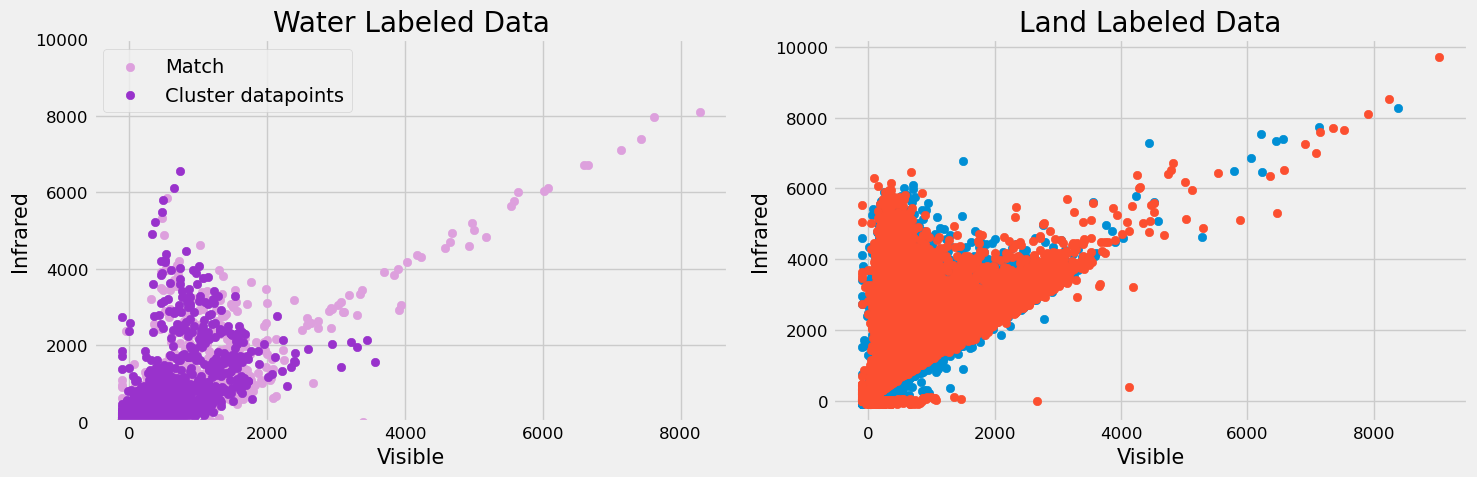

In [57]:
# fig, ax =  plt.subplots(1, 2,figsize=(15, 5))

# cluster_X_land = X_land.iloc[cluster_sample_land]
# cluster_X_water = X_water.iloc[cluster_sample_water]
# match_X_land = X_land.iloc[match_sample_land]
# match_X_water = X_water.iloc[match_sample_water]

# tick_size = 12
# label_s = 15


    
# ax[0].tick_params(axis='both', which='major', labelsize=tick_size)
# ax[0].scatter(match_X_water['sur_refl_b01_1'],match_X_water['sur_refl_b02_1'],label='Match',c='plum')#,cmap='PuRd')
# ax[0].scatter(cluster_X_water['sur_refl_b01_1'],cluster_X_water['sur_refl_b02_1'], c='darkorchid', label='Cluster datapoints') 
# ax[0].legend()
# ax[0].set_ylim(0,10000)
# ax[0].set_title("Water Labeled Data")
# ax[0].set_xlabel('Visible',size=label_s)
# ax[0].set_ylabel('Infrared',size=label_s)

# ax[1].tick_params(axis='both', which='major', labelsize=tick_size)
# ax[1].scatter(match_X_land['sur_refl_b01_1'],match_X_land['sur_refl_b02_1']) #,cmap='PuRd')
# ax[1].scatter(cluster_X_land['sur_refl_b01_1'],cluster_X_land['sur_refl_b02_1']) 
# ax[1].set_title("Land Labeled Data")

# ax[1].set_xlabel('Visible',size=label_s)
# ax[1].set_ylabel('Infrared',size=label_s)

# plt.tight_layout()
# # plt.savefig('all_datapoints_chosen_clusters.png',dpi=300)
# # plt.show()


### Plotting paramater space

In [48]:
#############################
# VERSION 4.2.1 (targeted 500k points)
TILE_IN_v421 = 'Golden'#v4.2.1
DATA_VERSION_v421 ='v4.2.1'
offsets_indexes_v421 = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
#############################

training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION_v421}'
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN_v421))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

print(data_paths)
data_path_v421 = data_paths[0]
print(data_path_v421)

colsToDrop = [
            # 'sur_refl_b01_1','sur_refl_b02_1',
            'sur_refl_b03_1','sur_refl_b04_1',
            'sur_refl_b05_1','sur_refl_b06_1',
            # 'sur_refl_b07_1', 'ndvi',
            'ndwi1','ndwi2'
            ]

colsToDropTraining_v421 = colsToDrop.copy()
colsToDropTraining_v421.extend(offsets_indexes_v421)
v_names = ['sur_refl_b01_1','sur_refl_b02_1',
           'sur_refl_b03_1','sur_refl_b04_1',
           'sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi',
           'ndwi1','ndwi2']

X_v421, X_test_v421, y_v421, y_test_v421 = load_data(fpath=data_path_v421,
             colsToDrop=colsToDropTraining_v421,
             dataType=DATA_TYPE,
             splitXY=True,
             imbalance=False,
             trainTestSplit=True)


['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.1/MOD09_Golden_Masked_986161_4_2_1.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.1/MOD09_Golden_Masked_986161_4_2_1.parquet.gzip


In [ ]:

# X_v421no = X_v421.copy()
# y_v421no = y_v421.copy()
# outlier_inds = X_v421[X_v421['sur_refl_b01_1'] > outlier_threshold].index
# X_v421no.drop(outlier_inds, inplace=True)
# y_v421no.drop(outlier_inds, inplace=True)

# print(f' Removing {len(X_v421) - len(X_v421no)} outliers')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


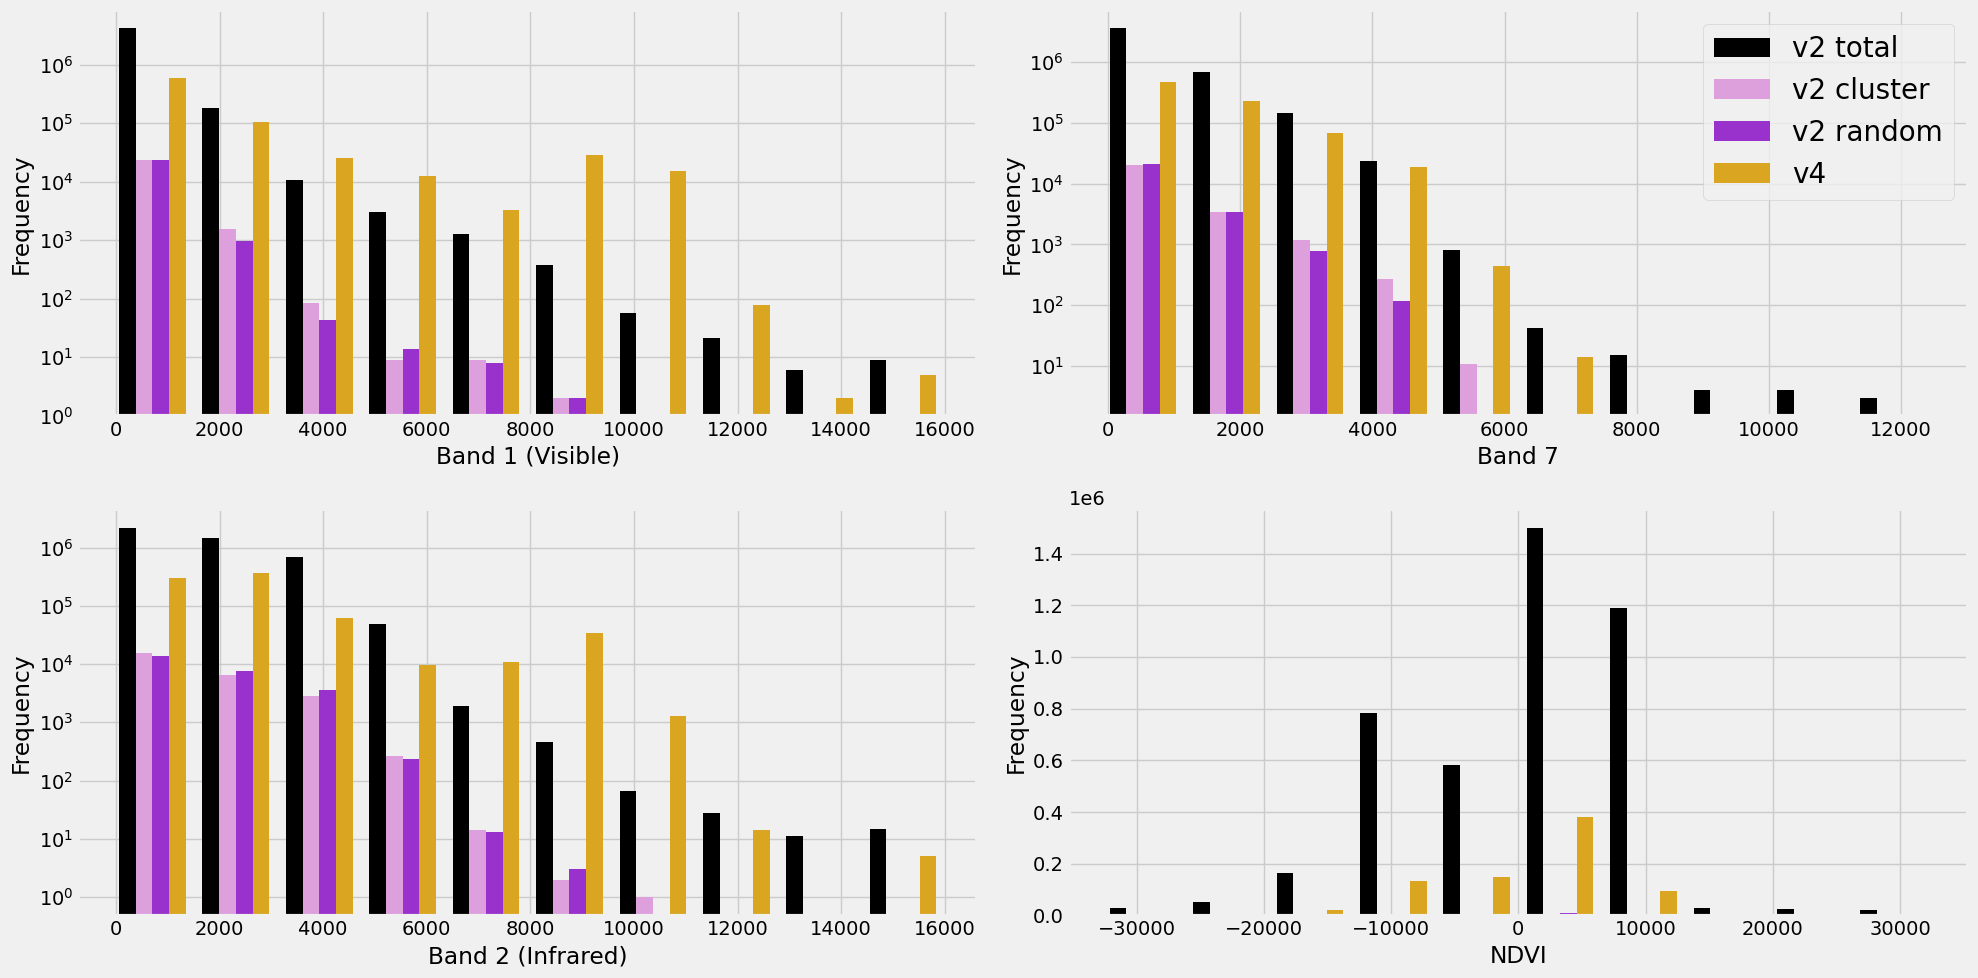

In [72]:
fig, ax = plt.subplots(2, 2,figsize=(20, 10))
var=0
for col in range(2):
    for row in range(2):
        ax[col, row].set_ylabel('Frequency') 
        variable=X_land.columns[var]
        if 'refl_b01' in variable: real_name_var = 'Band 1 (Visible)'
        if 'refl_b02' in variable: real_name_var = 'Band 2 (Infrared)'
        if 'refl_b07' in variable: real_name_var = 'Band 7'
        if 'ndv' in variable: real_name_var = 'NDVI'
        
        if 'ndvi' in variable: 
            # var_bins = bin_boundaries
            log_values = False
        else: 
            # var_bins = None
            log_values = True
        ax[row, col].hist(
            [ 
                X[variable],
                X_cluster[variable],
                X_match[variable],
                X_v421[variable]
            ],
            label=[
                'v2 total',
                'v2 cluster',
                'v2 random',
                'v4'
            ],
            color=[
                'black',
                'plum',
                'darkorchid',
                'goldenrod'
            ], log=log_values
        ) 
        ax[row, col].set_xlabel(f'{real_name_var}')
        var+=1
    ax[0,1].legend(loc='upper right',fontsize=20)
plt.tight_layout()
plt.savefig('Frequency_diagram_all.png',dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


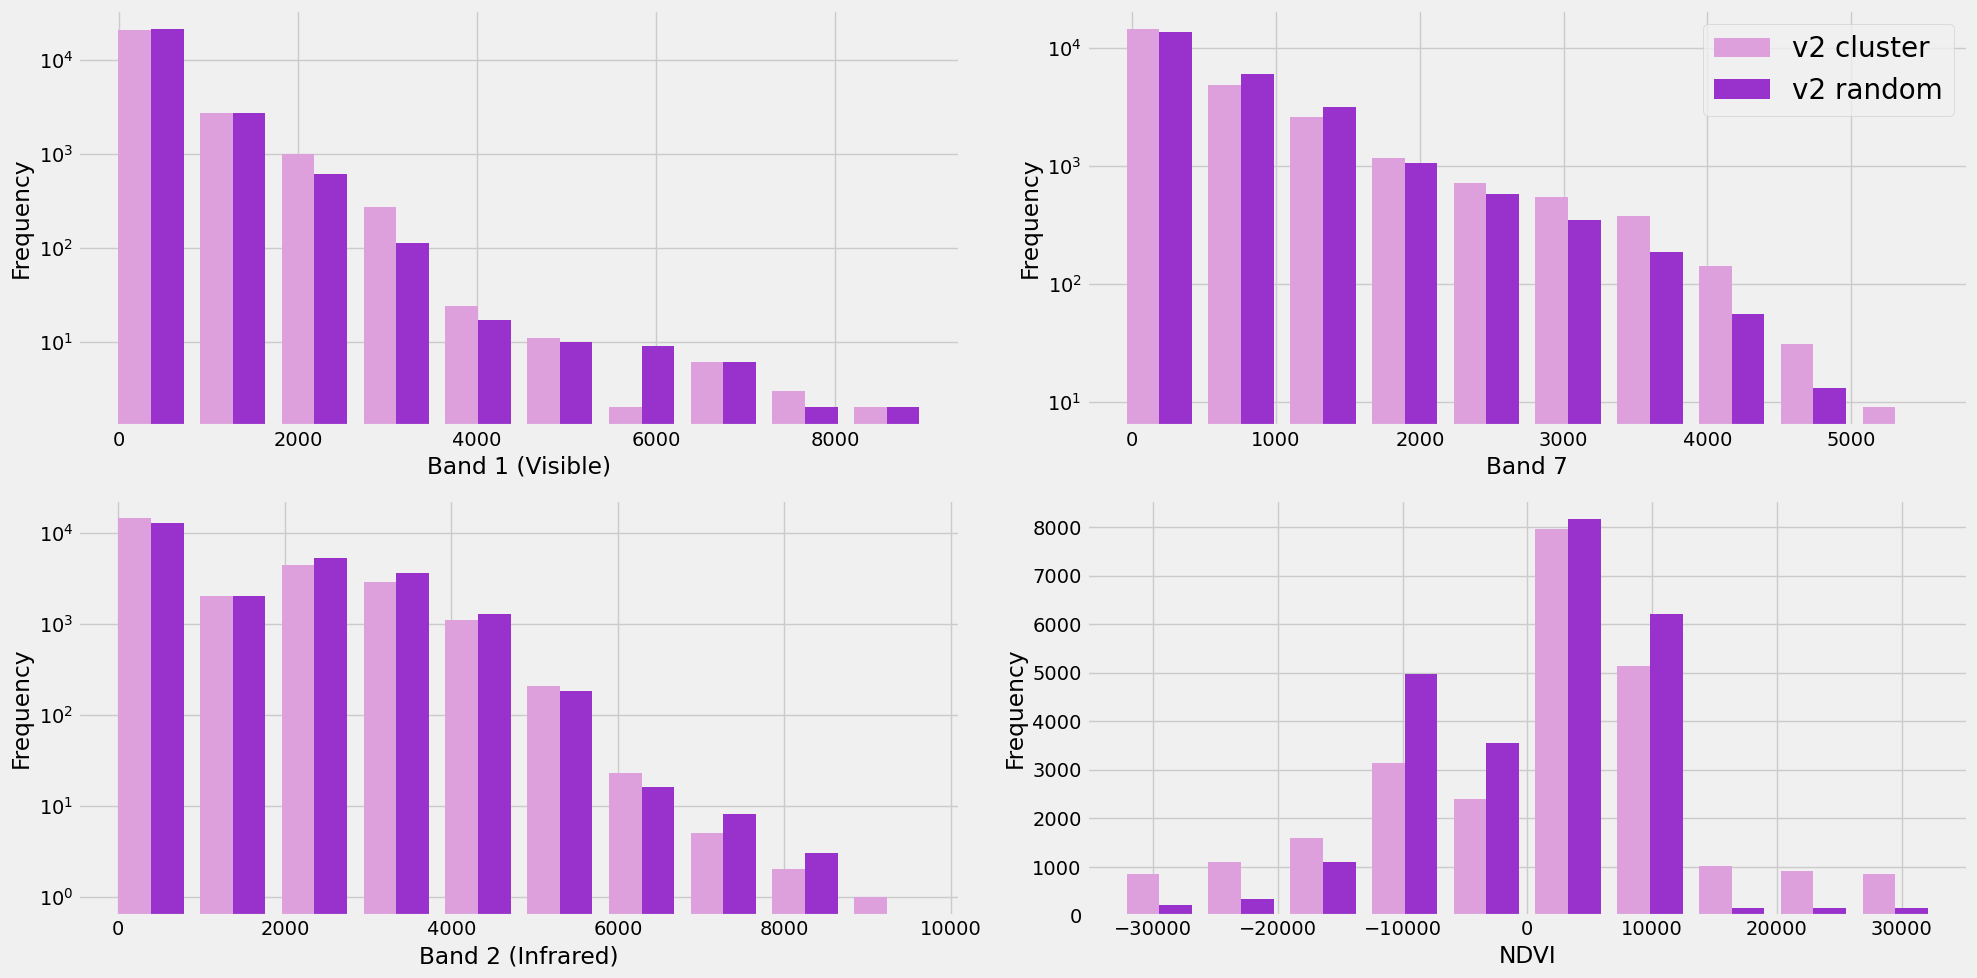

In [71]:
fig, ax = plt.subplots(2, 2,figsize=(20, 10))
var=0
for col in range(2):
    for row in range(2):
        ax[col, row].set_ylabel('Frequency') 
        variable=X_land.columns[var]
        if 'refl_b01' in variable: real_name_var = 'Band 1 (Visible)'
        if 'refl_b02' in variable: real_name_var = 'Band 2 (Infrared)'
        if 'refl_b07' in variable: real_name_var = 'Band 7'
        if 'ndv' in variable: real_name_var = 'NDVI'
        
        if 'ndvi' in variable: 
            # var_bins = bin_boundaries
            log_values = False
        else: 
            # var_bins = None
            log_values = True
        ax[row, col].hist(
            [ 
                X_cluster[variable],
                X_match[variable],
            ],
            label=[
                'v2 cluster',
                'v2 random',
                'v4'
            ],
            color=[
                'plum',
                'darkorchid',
            ], log=log_values
        ) 
        ax[row, col].set_xlabel(f'{real_name_var}')
        var+=1
    ax[0,1].legend(loc='upper right',fontsize=20)
plt.tight_layout()
plt.savefig('Frequency_diagram_v2_comparison.png',dpi=300)
plt.show()

## Random forest

In [ ]:
print(X_match[X_match['sur_refl_b01_1'] > outlier_threshold])
print(X_cluster[X_cluster['sur_refl_b01_1'] > outlier_threshold])
print(X_no_outlier[X_no_outlier['sur_refl_b01_1'] > outlier_threshold])
print(X_v421no[X_v421no['sur_refl_b01_1'] > outlier_threshold])

In [ ]:
#####################################################################
# HERE IS WHERE TO CHANGE THE X,Y DATASET USED FOR TRAINING
#####################################################################

X_chosen = X_cluster
y_chosen = y_cluster
out_file = f'rfa_models/MODIS_RFA_v201_Cluster_no-outlier-cluster'

In [ ]:
fig, ax =  plt.subplots(1, 2,figsize=(15, 5))

cluster_X_land = X_land.iloc[cluster_sample_land]
cluster_X_water = X_water.iloc[cluster_sample_water]

tick_size = 12
label_s = 15

ax[0].tick_params(axis='both', which='major', labelsize=tick_size)
# ax[0].scatter(X_water['sur_refl_b01_1'],X_water['sur_refl_b02_1'],c=kmeans_output_water_random)#,cmap='PuRd')
ax[0].scatter(cluster_X_water['sur_refl_b01_1'],cluster_X_water['sur_refl_b02_1']) 
ax[0].set_title("Water Datapoints")
ax[0].set_xlabel('Visible',size=label_s)
ax[0].set_ylabel('Infrared',size=label_s)

ax[1].tick_params(axis='both', which='major', labelsize=tick_size)
# ax[1].scatter(X_land['sur_refl_b01_1'],X_land['sur_refl_b02_1'],c=kmeans_output_land_random) #,cmap='PuRd')
ax[1].scatter(cluster_X_land['sur_refl_b01_1'],cluster_X_land['sur_refl_b02_1']) 
ax[1].set_title("Land Datapoints")
# ax[1].set_xlim(0,10000)
ax[1].set_xlabel('Visible',size=label_s)
ax[1].set_ylabel('Infrared',size=label_s)

# ax[2].tick_params(axis='both', which='major', labelsize=tick_size)
# ax[2].scatter(cluster_X_water['sur_refl_b01_1'],cluster_X_water['sur_refl_b02_1']) 
# ax[2].set_title("Water Cluster")
# ax[2].set_xlabel('Visible',size=label_s)
# ax[2].set_ylabel('Infrared',size=label_s)

# ax[3].tick_params(axis='both', which='major', labelsize=tick_size)
# ax[3].scatter(cluster_X_land['sur_refl_b01_1'],cluster_X_land['sur_refl_b02_1']) 
# ax[3].set_title("Land Cluster")
# ax[3].set_xlim(0,12000)
# ax[3].set_ylim(0,14000)#Datapoints")
# ax[3].set_xlabel('Visible',size=label_s)
# ax[3].set_ylabel('Infrared',size=label_s)


plt.show()

In [ ]:
def cpu_rf_objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
 
    param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': trial.suggest_categorical('bootstrap', bootstrap),
                       'criterion':'gini', 
                       #'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 1e-8, 1.0, log=True), 
                       'max_features':trial.suggest_categorical('max_features', max_features), 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       # 'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, val_idx) in enumerate(cv.split(X_chosen,  y_chosen)):    
        X_train, X_val = X_chosen.iloc[train_idx], X_chosen.iloc[val_idx]
        y_train, y_val = y_chosen.iloc[train_idx],  y_chosen.iloc[val_idx]   
        
        model = skRF(**param)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

search_space={
    "n_estimators": [75, 100, 125, 150, 175, 200, 250, 300, 400, 500],
    "max_depth" : [5,10, 30, 50, 80, 90, 100, 110],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "min_samples_split" : [2, 4, 8, 10],
    "bootstrap" : [True, False],
    "max_features" : ['auto', 'sqrt', 'log2'],
    
}
TREES_AND_DEPTH_ONLY = False
GRID_SEARCH = True

### Training RF

Change modeling type below e.g.,

study.optimize(cpu_***rf***_objective, n_trials=25, timeout=30*600)

vs

study.optimize(cpu_***xgb***_objective, n_trials=25, timeout=30*600)


In [ ]:
%%time

optuna.logging.set_verbosity(optuna.logging.INFO)
if GRID_SEARCH:
    study = optuna.create_study(study_name='RF Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(search_space))
    
else:
    study = optuna.create_study(study_name='RF Tuning',
                                direction='maximize')

study.optimize(cpu_rf_objective, n_trials=25, timeout=30*600)

In [ ]:
trials = study.best_trials            
max_trial_score = max([trial.values[0] for trial in trials])
max_trial_params = [trial.params for trial in trials 
                        if trial.values[0] == max_trial_score][0]
max_trial_params['n_jobs'] = -1
score_print = int(np.round(max_trial_score,4)*1000)
print(score_print)
score_out_file = f'{out_file}_MaxScore{score_print}.pkl'
print(score_out_file)

In [ ]:
hyperparameters = max_trial_params
hyperparameters['n_jobs'] = -1
print('Using these params:')
print(hyperparameters)
tuned_classifier = skRF(**hyperparameters)

Change the data in the .fit() function below e.g. 

tuned_classifier.fit(***X_cluster, y_cluster***)

vs

tuned_classifier.fit(***X_match, y_match***)

In [ ]:
%%time 
tuned_classifier.fit(X_chosen, y_chosen)

Change the filename below e.g., 

out_file = f'rfa_models/MODIS_RFA_v201_***EBcluster***_MaxScore{score_print}_sfcref127ndvi.pkl'

vs

out_file = f'rfa_models/MODIS_RFA_v201_***EBmatch***_MaxScore{score_print}_sfcref127ndvi.pkl'

In [ ]:
pickle.dump(tuned_classifier, open(score_out_file, 'wb'))

In [ ]:
# pickled_model = pickle.load(open(out_file, 'rb'))
# print(pickled_model)